In [1]:
from model.types import MarketDemandSupply
from model.run import load_config, run, post_processing
import matplotlib.pyplot as plt
from model.mechanism.amm_k import amm_k_mechanism
from model.mechanism.treasury import liq_backing_mechanism,treasury_stables_mechanism,floating_supply_mechanism,liq_ohm_mechanism
from model.policy.rbs_price import lower_target_policy,upper_target_policy

params = {"demand_factor": [10],
         "supply_factor": [10],
         "initial_reserves_volatile":[17000000], # setting it as constant since in this simulation we don't use it at all.
         "max_liq_ratio":[0.14375],  # LiquidityUSD : reservesUSD ratio --> 1:1 = 0.5
         "target_ma":[30], # number of days
         "lower_wall":[0.15],
         "upper_wall":[0.15],
         "lower_cushion":[.075],
         "upper_cushion":[.075],
          "reinstate_window": [30],
          "max_outflow_rate": [0.05],
          "reward_rate_policy": ["Flat"]
         }


initialstate = { # variable values borrowed from liquidity-olympus/simulation.ipynb
            'supply':30000000,
            "liq_stables": 21000000,
            "reserves_stables":200000000,
            "reserves_volatile":17000000,
            "price":9,
            "reward_rate": 0.000198,

            "market_demand_supply": MarketDemandSupply(total_supply = 50,
                                                   total_demand = 50),
                                                   
            # treasury policy
            'target_liq_ratio_reached':False,
            'reserves_in':0,
            'supply':25000000,

            # RBS related
            'ma_target':9,
            # market transaction variables
            'ask_change_ohm':0,
            'bid_change_ohm':0,
            "net_flow": None
            }
# initialize parameters that are decided by other parameters
initialstate['amm_k'] = amm_k_mechanism(initialstate)
initialstate['price_history']=[initialstate['price']]

initialstate['lb_target'] = initialstate['ma_target']
initialstate['price_target']=initialstate['ma_target']

initialstate['liq_ohm'] = liq_ohm_mechanism(initialstate['liq_stables'],initialstate['price'])
initialstate['floating_supply'] = floating_supply_mechanism(initialstate['supply'],initialstate['liq_ohm'])



initialstate['treasury_stables'] = treasury_stables_mechanism(initialstate['liq_stables'],initialstate['reserves_stables'])
initialstate['liq_backing'] = liq_backing_mechanism(initialstate['treasury_stables'],params['initial_reserves_volatile'][0])
initialstate['target_walls'] = [lower_target_policy(initialstate['price_target'], params['lower_wall'][0]),
                                upper_target_policy(initialstate['price_target'], params['upper_wall'][0])]
initialstate['target_cushions'] = [lower_target_policy(initialstate['price_target'], params['lower_cushion'][0]),
                                    upper_target_policy(initialstate['price_target'], params['upper_cushion'][0])]
initialstate['bid_counter'],initialstate['ask_counter'] = [0] * params["reinstate_window"][0],[0]* params["reinstate_window"][0]

nrun = 2
nstep = 365
exp = load_config(nrun, params, initialstate, nstep)
raw = run(exp)
df = post_processing(raw)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 365, 12, 2, 25)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (365, 12, 2, 25)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 4.73s


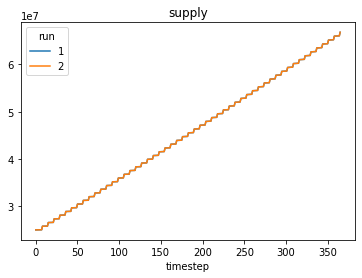

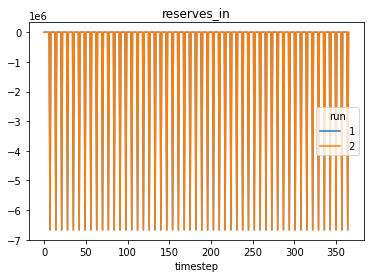

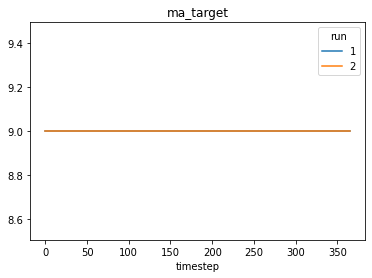

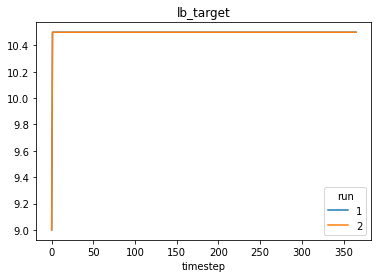

In [2]:
for col in ["supply", "reserves_in", "ma_target", "lb_target",
           "control_ask", "control_bid"]:
    df.pivot("timestep","run", col).plot(kind='line')
    plt.title(col)
    plt.show()